In [2]:
# Add root directory of project to sys path so that Jupyter notebook can import from root/src/..
import sys
import os

# Get the absolute path of the parent directory of the current notebook
notebook_dir = os.path.abspath('')
project_root = os.path.dirname(notebook_dir)  # Assumes the notebook is in root/notebooks

# Add the project root to the sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
# imports
import wave # standard available in Python >2.x
import numpy as np

from src.utils.audio_processor import AudioProcessor
import matplotlib.pyplot as plt
import matplotlib.colors as colors


In [4]:
# Open the .wav file
with wave.open('../data/audio_samples/synth_saw_decay.wav', 'r') as wav_file:
    # Get the sampling rate
    sampling_rate = wav_file.getframerate()
    print(f"The sampling rate is: {sampling_rate} Hz")
    
    # Extract audio frames
    signal = wav_file.readframes(wav_file.getnframes())
    
    # Convert audio frames to numpy array
    # The 'np.frombuffer' function is used to interpret the byte data as an array.
    # The 'dtype' argument depends on the number of bytes per sample, which can be determined by 'wav_file.getsampwidth()'
    #  MDJ: print(wav_file.getsampwidth()): 2, i.e., 2 bytes = 16bits
    # 'np.int16' is commonly used for 16-bit audio files, adjust as needed.
    waveform = np.frombuffer(signal, dtype=np.int16) # for stereo this returns: [L1, R1, L2, R2, ...] 

    # If the audio file is stereo (2 channels), you might want to reshape the array
    if wav_file.getnchannels() == 2:
        waveform_reshaped = np.reshape(waveform, (-1, 2)) # now we get stereo like this: [ [L1, R1], [L2, R2], ... ]
        waveform_mono_avg = waveform_reshaped.mean(axis=1) # results in [(L1+R1)/2, (L2+R2)/2, ...]
        waveform_mono_sum = waveform_reshaped.sum(axis=1) # results in [L1+R1, L2+R2, ...]

# Now 'waveform' is a numpy array containing the audio data

The sampling rate is: 44100 Hz


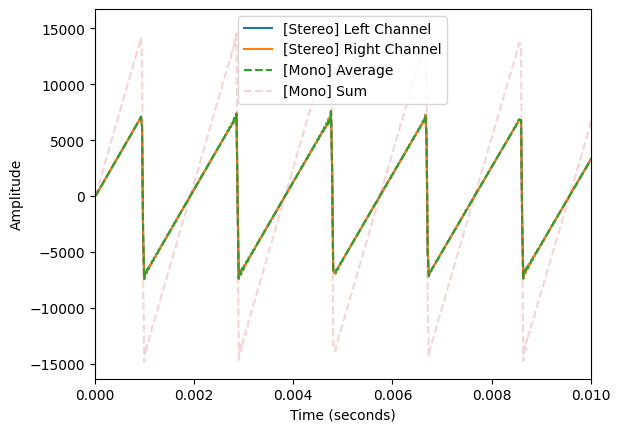

In [5]:
# Plot the waveforms
time = np.arange(len(waveform_reshaped)) / sampling_rate
plt.plot(time, waveform_reshaped[:, 0], label = '[Stereo] Left Channel')
plt.plot(time, waveform_reshaped[:, 1], label = '[Stereo] Right Channel')
plt.plot(time, waveform_mono_avg, label = '[Mono] Average', linestyle = 'dashed')
plt.plot(time, waveform_mono_sum, label = '[Mono] Sum', linestyle = 'dashed', alpha=0.2)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim(0, 0.01)
plt.legend()
plt.show()

In [6]:
# Plot the spectrogram using our custom AudioProcessor class
audio = AudioProcessor(audio_sample=waveform_mono_avg, sampling_freq=sampling_rate)
audio.calculate_spectrogram()

# Call plotting functions
plt.pcolormesh(audio.spectrogram.time, audio.spectrogram.frequency, audio.spectrogram.decibels, shading='gouraud')
plt.yscale('log')
plt.ylim(bottom=20, top=sampling_rate/2) # 20 Hz is lower limit of human hearing
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Intensity [dB]')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'time'

In [ ]:
print(audio.spectrogram.frequency.shape)

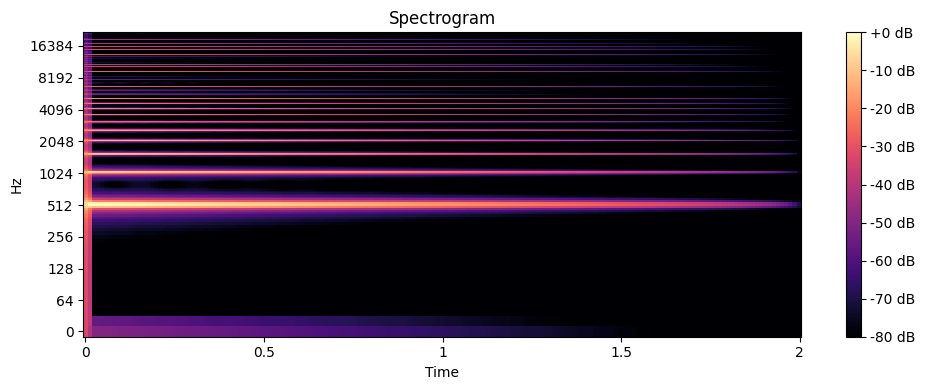

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load an audio file
y = waveform_mono_avg
sr = sampling_rate

# Compute the spectrogram (magnitude, not complex)
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

In [20]:
S_db.shape

(1025, 173)

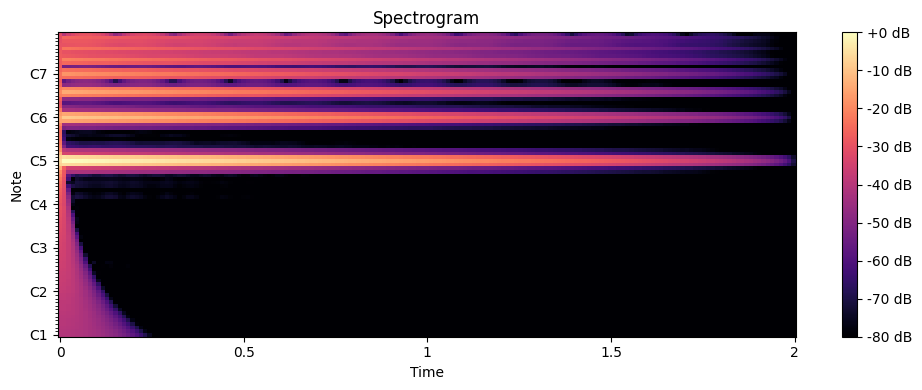

In [8]:
# Compute Constant-Q Transform (CQT)
C = librosa.cqt(y, sr=sr, bins_per_octave=12)
C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(C_db, sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

In [9]:
C_db.shape

(84, 173)

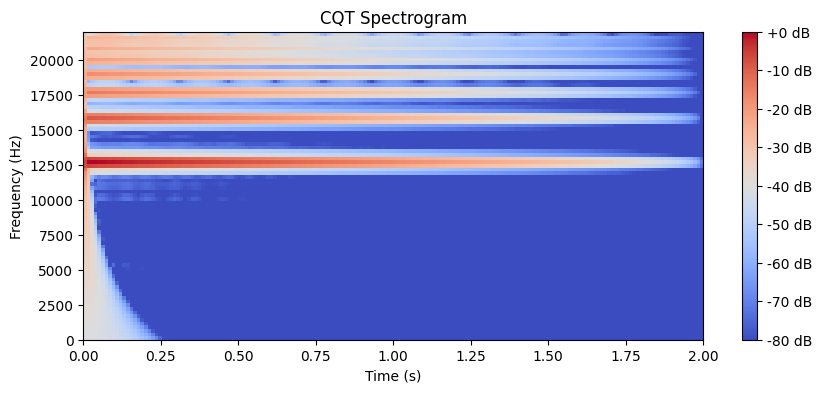

In [10]:
# Compute Constant-Q Transform (CQT)
C = librosa.cqt(y, sr=sr)
C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)

# Plotting with plt.imshow, fixing orientation and axis
plt.figure(figsize=(10, 4))
plt.imshow(C_db, aspect='auto', origin='lower', 
           extent=[0, 2.0, 0, sr/2],
           cmap='coolwarm', interpolation='nearest')
plt.colorbar(format='%+2.0f dB')
plt.title('CQT Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
# plt.yscale('symlog', linthresh=librosa.note_to_hz('C1'))  # Setting log scale for y-axis
plt.show()

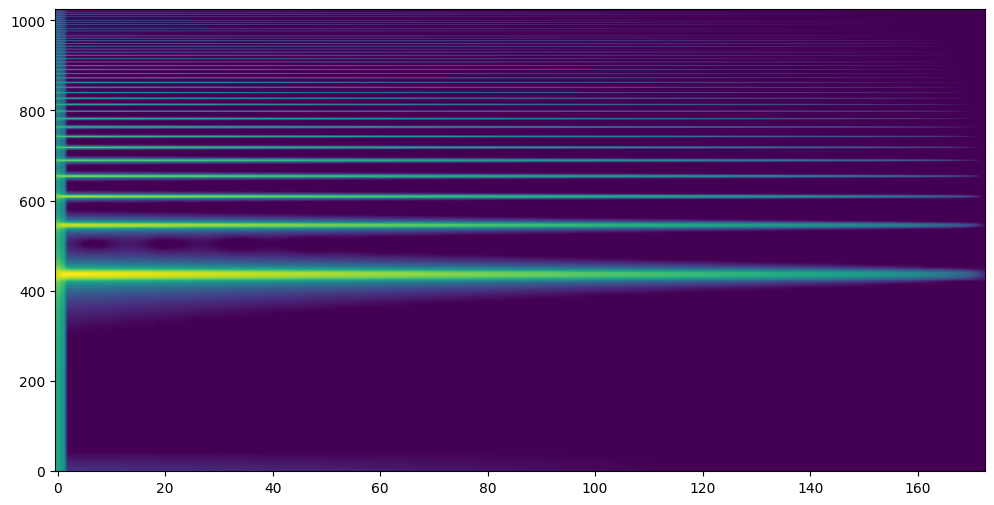

In [11]:
import scipy.interpolate

def log_scale_spectrogram(S_db, sr, bins_per_octave=12, fmin=None):
    if fmin is None:
        fmin = librosa.note_to_hz('C1')  # Set a reasonable minimum frequency, e.g., C1 ~32 Hz
    
    freqs = librosa.fft_frequencies(sr=sr, n_fft=(S_db.shape[0]-1)*2)
    log_freqs = np.logspace(np.log10(fmin), np.log10(freqs[-1]), num=S_db.shape[0])
    
    # Interpolation function
    interp = scipy.interpolate.interp1d(freqs, S_db, kind='linear', axis=0, fill_value='extrapolate')
    
    # Log-scaled spectrogram
    log_S_db = interp(log_freqs)
    
    return log_S_db

# Apply the function
log_S_db = log_scale_spectrogram(S_db, sr)

plt.figure(figsize=(12, 6)) 
plt.imshow(log_S_db, aspect='auto', origin='lower')

In [12]:
log_S_db.shape

(1025, 173)

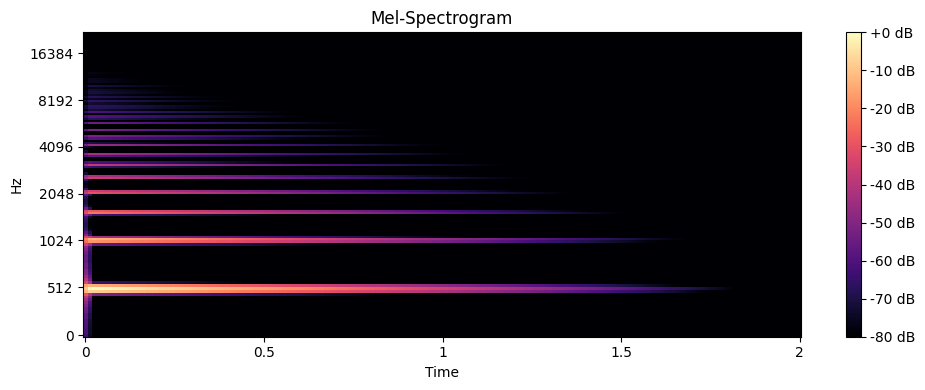

In [31]:
# Compute mel-scaled spectrogram
S_mel = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=512, n_mels=128)  # You can adjust 'n_mels' for resolution
S_db_mel = librosa.amplitude_to_db(S_mel, ref=np.max)

# Plot the mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db_mel, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.show()

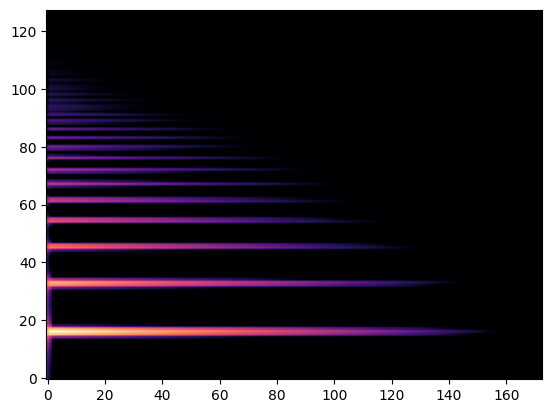

In [32]:
plt.imshow(S_db_mel, aspect='auto', origin='lower', cmap='magma')

In [29]:
88200/512

172.265625

In [30]:
S_db_mel.shape

(batch, 128, 173, 1)

(206, 429)

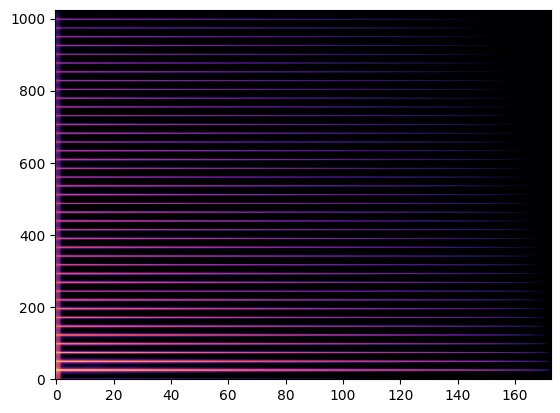

In [17]:
plt.imshow(S_db, aspect='auto', origin='lower', cmap='magma')